# Analysis of the Southern Women Data Set
## DATA620 Week 6 Assignment
### Thomas Detzel and Erik Nylander

In [1]:
import networkx as nx
import networkx.algorithms.bipartite as bp
import math
import numpy as np
from operator import itemgetter, attrgetter
import matplotlib.pyplot as plot
import matplotlib.colors as colors
%matplotlib inline
plot.rcParams['figure.figsize'] = (21, 14)

'''
## plotly stuff
import plotly.plotly as py
from plotly.graph_objs import *
from plotly.tools import FigureFactory as FF
import plotly.tools as tls
tls.set_credentials_file(username='tdetz', api_key='705bdng1xl')
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True) # run at the start of every ipython notebook to use plotly.offline
                     # this injects the plotly.js source files into the notebook
import plotly.graph_objs as go
import cufflinks as cf
'''

import pandas as pd
from collections import defaultdict
from scipy.cluster import hierarchy
from scipy.spatial import distance

## Introduction and findings

*Note: To hide/show code in this notebook, use the </> toggle button in the toolbar.*

In this assignment, we are asked to analyze a canonical set of bipartite data, the Davis Southern Club Women. We used NetworkX and Python to import, plot and analyze the data. We applied the island method and hierarchal clustering to identify subgroups and explore their internal connections, computed degree centrality, betweenness, closeness, and clustering meausures for a projected bipartite graph on the women. Results show that both the island method and hierarchal clustering identified two distinct groups in the data, each connected to different clubs/events. These two groups were themselves connected via a subset of bridging clubs/events. Four of the women appear to be boundary spanners. We also constructed a weighted bipartite graph projected on women and applied the island method, which identified the same subgroups found in the unweighted graph.

## 1. Import and review graph data

The Davis Southern Club Women data set is available [here](http://vlado.fmf.uni-lj.si/pub/networks/data/Ucinet/davis.dat) with a brief description of the data set and its background [here](http://vlado.fmf.uni-lj.si/pub/networks/data/ucinet/ucidata.htm#davis). This data set is also included with a both R and the NetworkX analysis packages. We have elected to use the data set that is included with the NetworkX package and load it below. The data comes to us as a bipartite graph and we show some of it's basic features below.

In [3]:
## get the graph data; imports as a bipartite graph
G = nx.davis_southern_women_graph()

In [4]:
nx.is_connected(G)

True

In [5]:
nx.is_directed(G)

False

In [6]:
nx.is_bipartite(G)

True

In [7]:
## this step is unnecessary, just a different way to reference the two node sets
women = G.graph['top']
clubs = G.graph['bottom']

In [8]:
## this is the more common way to do the same; women already are the top nodes, clubs on bottom
top_nodes, bottom_nodes = nx.bipartite.sets(G)

Now that we have our data set loaded in as a graph we can explore what we have. We see below the eighteen Southern Women that are included in the data and the fourteen social events that the women attended.

In [9]:
print ""
print "Women"
print "------------------"
for i in range(len(top_nodes)):
    print '%s    ' % (list(top_nodes)[i])


Women
------------------
Theresa Anderson    
Helen Lloyd    
Flora Price    
Katherina Rogers    
Nora Fayette    
Sylvia Avondale    
Verne Sanderson    
Olivia Carleton    
Eleanor Nye    
Brenda Rogers    
Frances Anderson    
Dorothy Murchison    
Ruth DeSand    
Laura Mandeville    
Evelyn Jefferson    
Charlotte McDowd    
Myra Liddel    
Pearl Oglethorpe    


In [10]:
print ""
print "Clubs"
print "-----"
for i in range(len(bottom_nodes)):
    print '%s    ' % (list(bottom_nodes)[i])


Clubs
-----
E11    
E10    
E13    
E12    
E14    
E9    
E8    
E5    
E4    
E7    
E6    
E1    
E3    
E2    


In [11]:
## all the nodes and their degrees (number of connections)
## nx.degree(G)
g_degrees = sorted(zip(nx.degree(G).values(), nx.degree(G).keys()), reverse=True)

print ''
print "Degrees     Node"
print '---------------------------'
for i in range(len(g_degrees)):
    print '%2d          %s' % (g_degrees[i][0], g_degrees[i][1])


Degrees     Node
---------------------------
14          E8
12          E9
10          E7
 8          Theresa Anderson
 8          Nora Fayette
 8          Evelyn Jefferson
 8          E6
 8          E5
 7          Sylvia Avondale
 7          Laura Mandeville
 7          Brenda Rogers
 6          Katherina Rogers
 6          E3
 6          E12
 5          Helen Lloyd
 5          E10
 4          Verne Sanderson
 4          Ruth DeSand
 4          Myra Liddel
 4          Frances Anderson
 4          Eleanor Nye
 4          E4
 4          E11
 4          Charlotte McDowd
 3          Pearl Oglethorpe
 3          E2
 3          E14
 3          E13
 3          E1
 2          Olivia Carleton
 2          Flora Price
 2          Dorothy Murchison


## 2. Plot the bipartite network

In this plot of the overall bipartite network, node size indicates degree and color indicates top (women) or bottom (club) nodes. Edges indicate which women participated in which club. There appears to be two subnetworks of women, and they are connected via clubs E7, E8 and E9, three clubs that have the highest degree centrality.

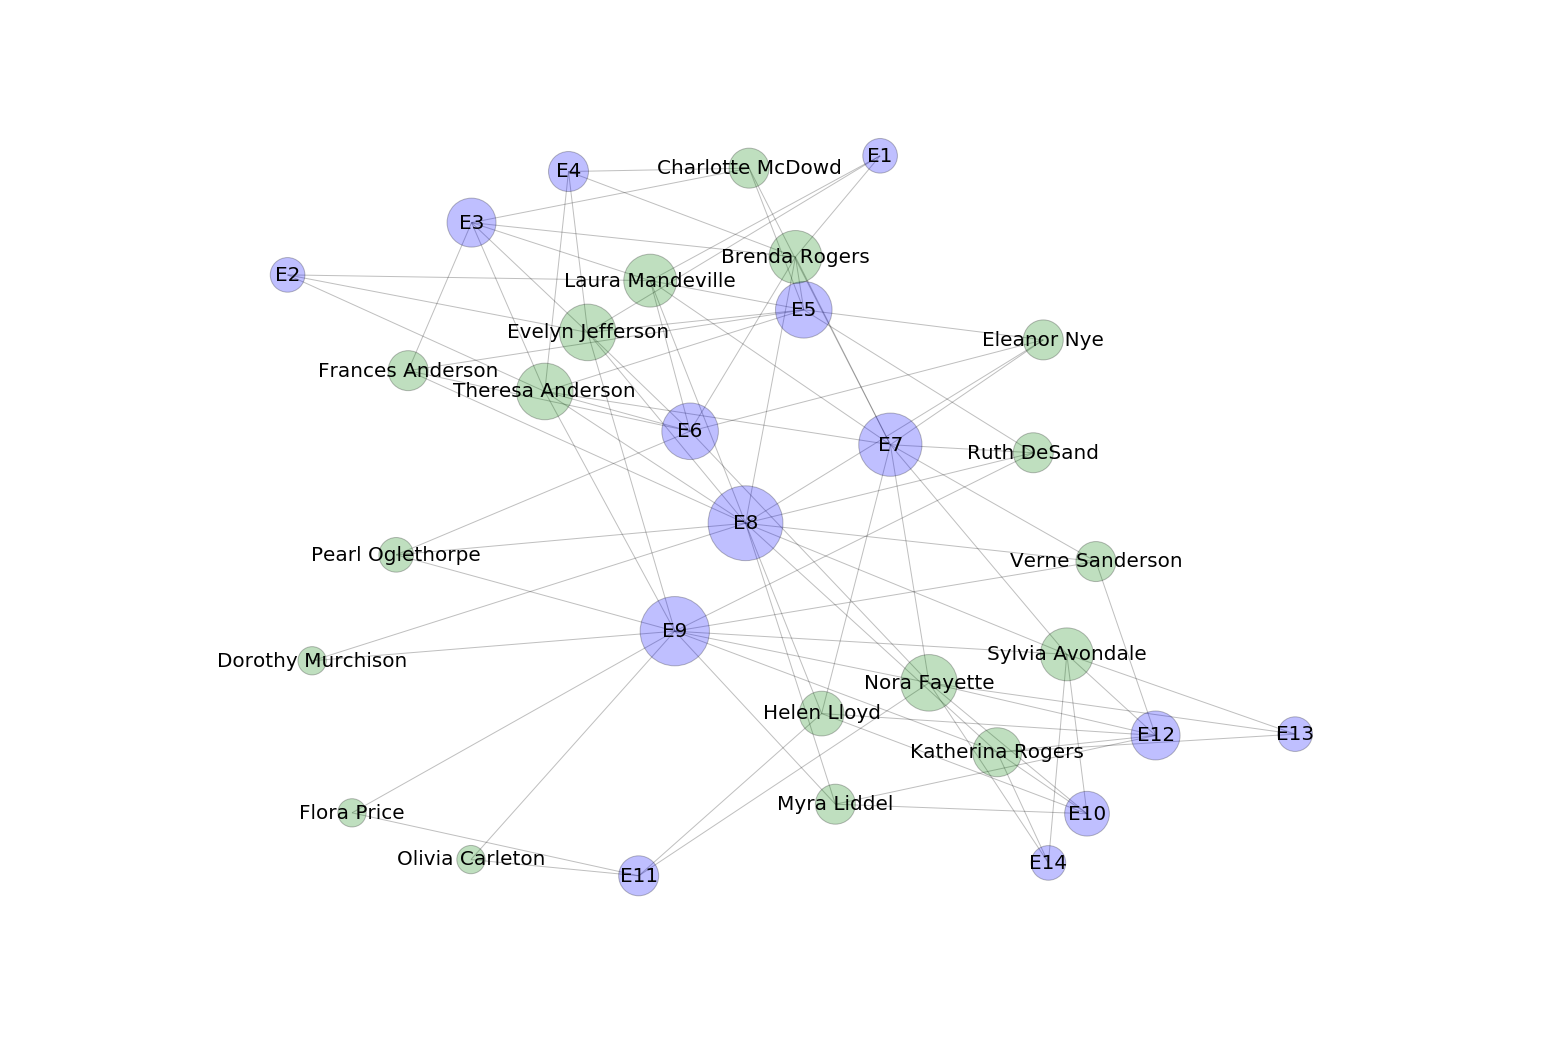

In [11]:
## plot the whole network, blue=clubs, red=women, node_size=G.degree

#plot.axis('off')

colors=[]
for n in G.degree().keys():
    if n in G.degree(women).keys():
        colors.append('g')
    else:
        colors.append('b')
        
d = G.degree()
nx.draw(G, node_size=[v*400 for v in d.values()], with_labels=True, node_color=colors, alpha=.25, font_size=20)
#plot.show()


## 3. Bipartite projection: Women
A bipartite projection creates a connection between Southern Women if they participate in the same club/social event. Verne Sanderson and six other Southern women had the same number of mutual club/social event connections: 17. Verne Sanderson's connections are shown in the second code block. We can see from our original graph that these associations involved Sanderson's participation in only 4 clubs/social events, but three (E7, E8 and E9) had the highest degree centrality. 

### 3.1 Degree centrality, projected graph

In [12]:
# project bipartite graph onto women nodes
# now the degrees are their connections with other women
# based on participation in the same club events
# reverse-sort the list

W = nx.bipartite.weighted_projected_graph(G, women)

wdegrees = sorted(zip(W.degree(women).values(), W.degree(women).keys()), reverse=True)

print ''
print "Degrees   Member"
print '---------------------------'
for i in range(len(wdegrees)):
    print '%d        %s' % (wdegrees[i][0], wdegrees[i][1])


Degrees   Member
---------------------------
17        Verne Sanderson
17        Theresa Anderson
17        Sylvia Avondale
17        Ruth DeSand
17        Nora Fayette
17        Helen Lloyd
17        Evelyn Jefferson
16        Pearl Oglethorpe
16        Myra Liddel
16        Katherina Rogers
16        Dorothy Murchison
15        Laura Mandeville
15        Frances Anderson
15        Eleanor Nye
15        Brenda Rogers
12        Olivia Carleton
12        Flora Price
11        Charlotte McDowd


### 3.2 Plot the bipartite projection

Node sizes are based on each woman's clustering coefficient, but it's difficult to visually segregate groups.

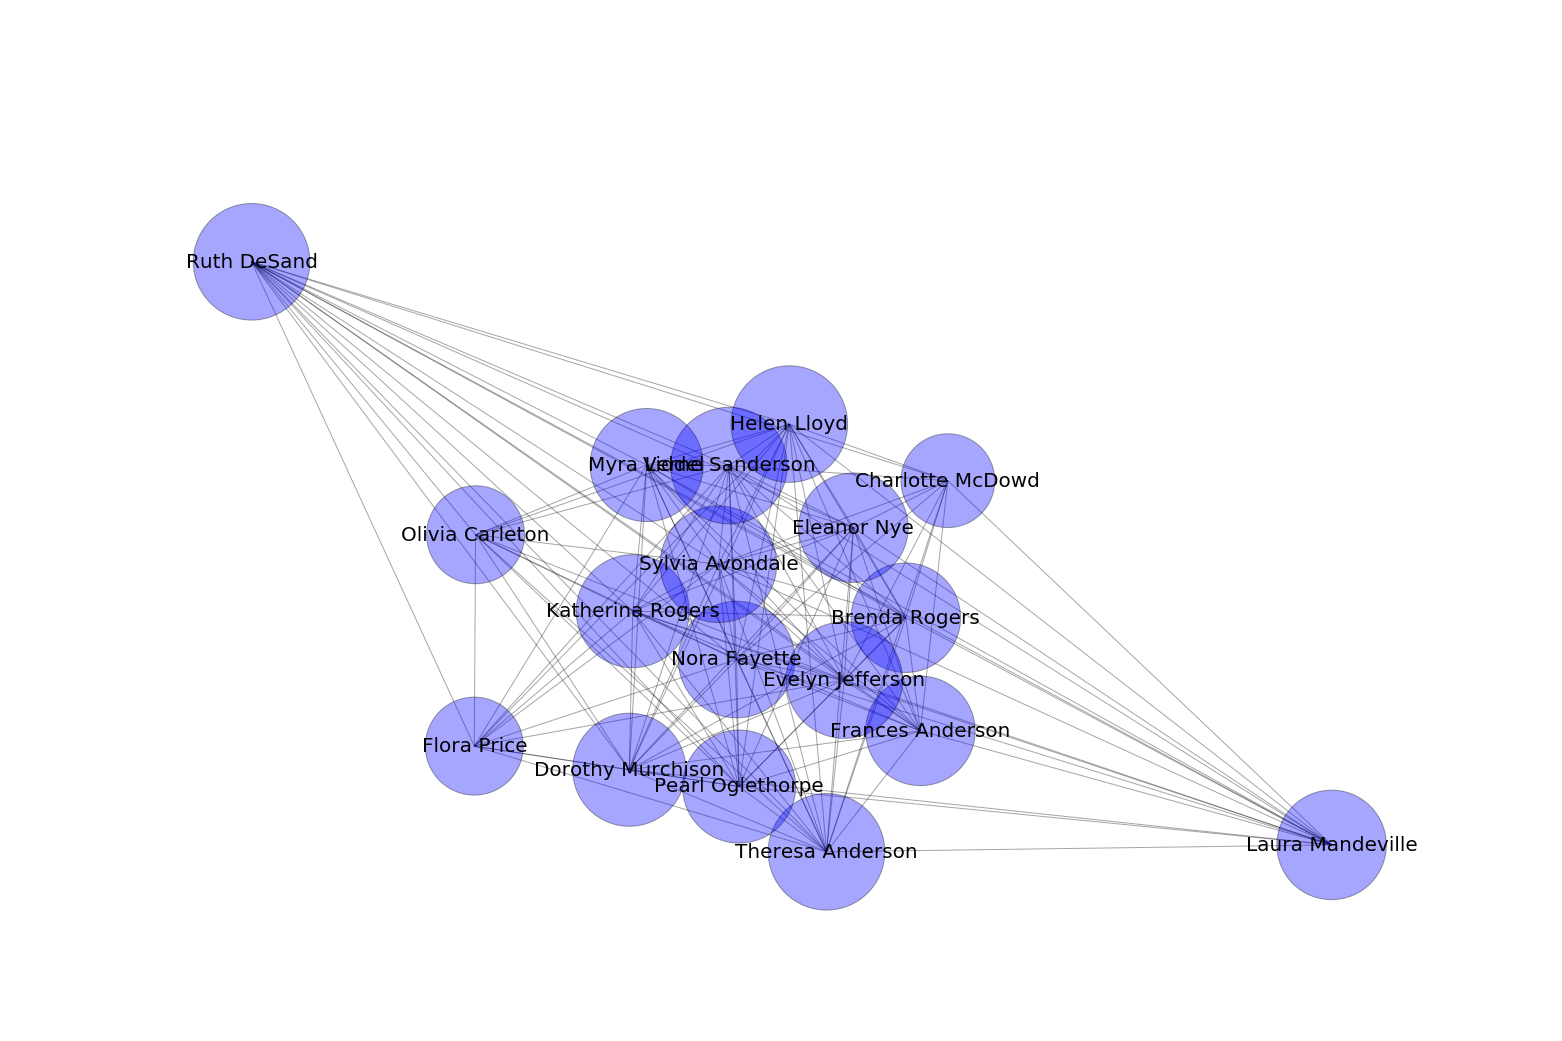

In [13]:
## plot the bipartite projection onto women

d = nx.degree(W)
nx.draw(W, node_size=[v*800 for v in d.values()], with_labels=True, node_color='b', alpha=.35, font_size=20)


### 3.3 Island Analysis -- Women
Using the island method helps separate the women into two distinct subgroups. We cab see from our analysis below that our best choice for a "water level depth" is 3. This keeps the largest group of women but divides them into two distinct groups.


In [14]:
## Implementing the Island Method to look for important subgroups. ##
def trim_edges(g, weight = 1):
    # Implements a trimming of the graph edges for the Island Analysis
    g2 = nx.Graph()
    for f, to, edata in g.edges(data=True):
        if edata['weight'] > weight:
            g2.add_edge(f,to,edata)
    return g2

def island_method(g, iterations = 5):
    # Iterates through the graph removing edges and returning the number of edges removed and
    #  the trimmed graph
    weights = [edata['weight'] for f,to,edata in g.edges(data=True)]
    mn=int(min(weights))
    mx=int(max(weights))
    step = int((mx-mn)/iterations)
    return [[threshold, trim_edges(g, threshold)] for threshold in range(mn,mx,step)]

In [15]:
## Running the Island Analysis on the graph. Will thow an error if the island_method is called with too many steps
cc = list(nx.connected_component_subgraphs(W))[0]
islands = island_method(cc)
print ''
print 'Depth  Women  Groups'
print '---------------------'
for island in islands:
    print(' %d      %2d      %d' 
          %(island[0], len(island[1]), len(list(nx.connected_component_subgraphs(island[1]))))) 


Depth  Women  Groups
---------------------
 1      18      1
 2      15      1
 3      14      2
 4       7      2
 5       7      2
 6       2      1


### 3.4 Plot of subgroups

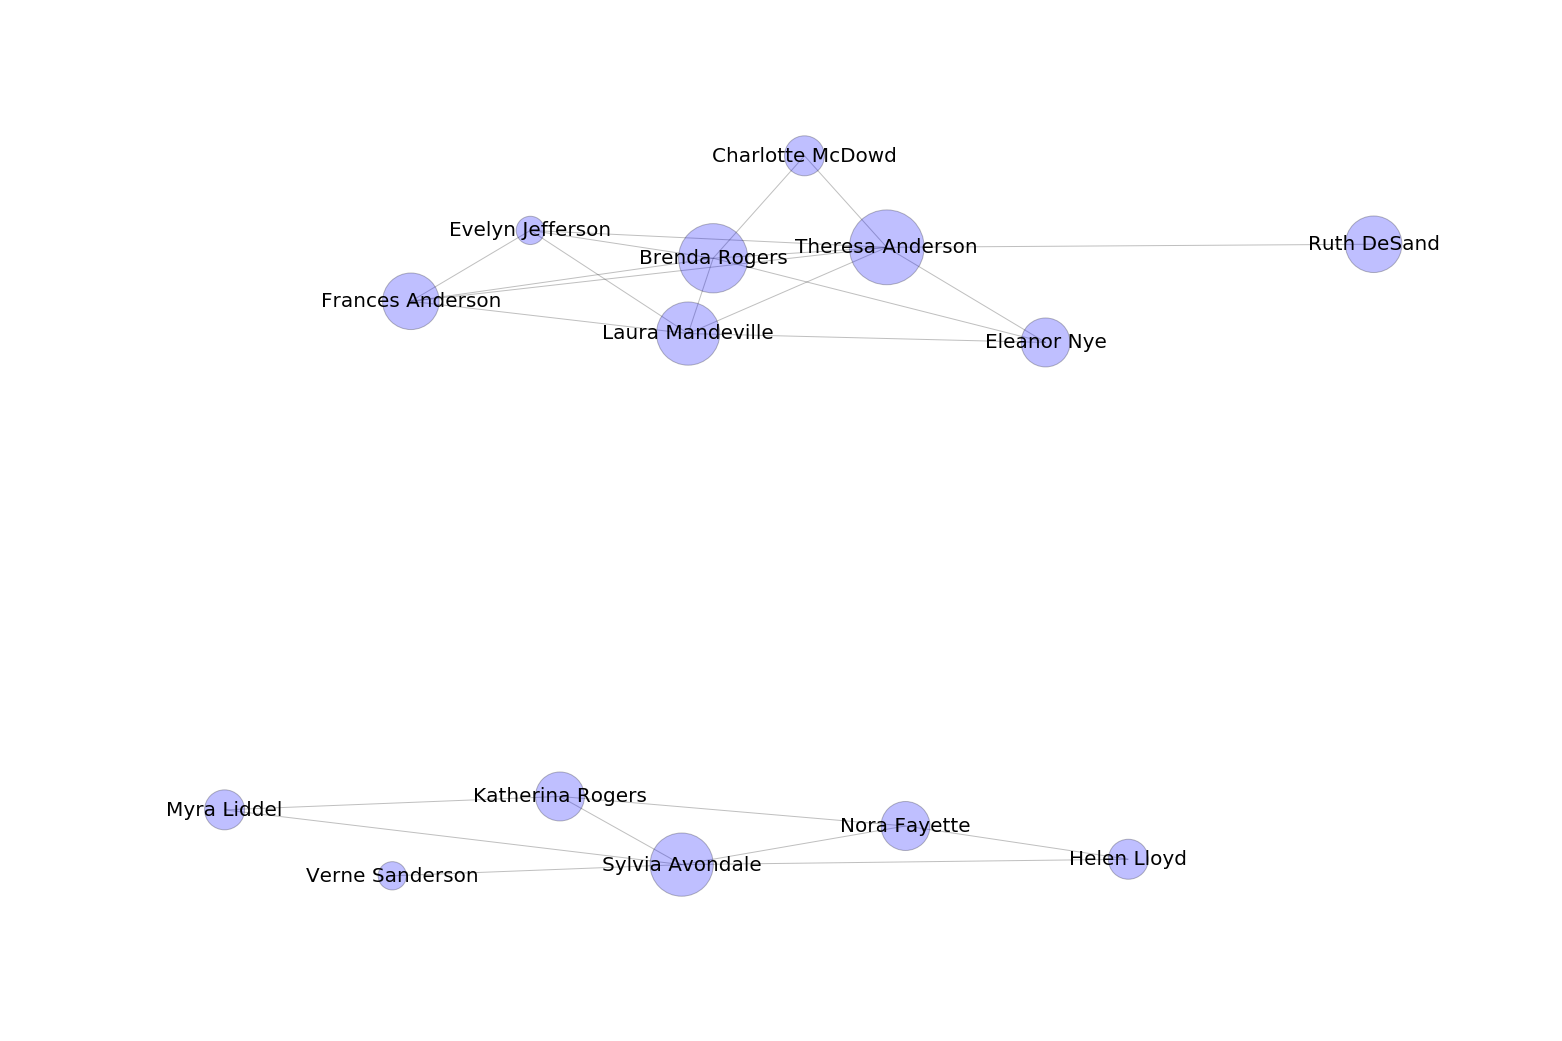

In [16]:
## Plotting the two graphs created by the island analysis

wc = trim_edges(W, 3)
dwc = wc.degree()
nx.draw(wc, node_size=[v*800 for v in dwc.values()], with_labels=True, node_color='b', alpha=.25, font_size=20)

### 3.5 Comparison of subgroups

Now that we have our distinct subgroups, we can identify who is most connected and the individuals that served as bridges.

#### Group 1

In [17]:
## Who is in the first subgroup?
wc1 = list(nx.connected_component_subgraphs(wc))[0]
wc1deg = sorted(zip(wc1.degree(women).values(), wc1.degree(women).keys()), reverse=True)

print ''
print "Links    Member"
print '--------------------------'
for i in range(len(wc1deg)):
    print '%d        %s' % (wc1deg[i][0], wc1deg[i][1])


Links    Member
--------------------------
7        Theresa Anderson
6        Brenda Rogers
5        Laura Mandeville
4        Frances Anderson
4        Evelyn Jefferson
3        Eleanor Nye
2        Charlotte McDowd
1        Ruth DeSand


#### Group 2

In [18]:
## Who is in the second subgroup?

wc2 = list(nx.connected_component_subgraphs(wc))[1]
wc2deg = sorted(zip(wc2.degree(women).values(), wc2.degree(women).keys()), reverse=True)

print ''
print "Links    Member"
print '--------------------------'
for i in range(len(wc2deg)):
    print '%d        %s' % (wc2deg[i][0], wc2deg[i][1])


Links    Member
--------------------------
5        Sylvia Avondale
3        Nora Fayette
3        Katherina Rogers
2        Myra Liddel
2        Helen Lloyd
1        Verne Sanderson


#### Boundary spanners
These women have links to both subgroups but are not as active within each group as other women.

In [19]:
## Who did we drop? These are our connectors between the two subgroups
connectors = list(set(W.degree(women).keys()) - set(wc.degree(women).keys()))
# print connectors
print ''
print 'Subgroup Connectors'
print '-------------------'
for i in range(len(connectors)):
    print connectors[i]


Subgroup Connectors
-------------------
Olivia Carleton
Dorothy Murchison
Pearl Oglethorpe
Flora Price


### 3.6 Island analysis -- Clubs/Social Events

Applying an island algorithm to the clubs doesn't yield subgroups. Southern Women may have had favorite clubs/social events, but they also attended many other events.

In [20]:
## Running the Island Analysis on the graph. Will thow an error if the island_method is called with too many steps
C = nx.bipartite.weighted_projected_graph(G, clubs)

cc = list(nx.connected_component_subgraphs(C))[0]
islands = island_method(cc)
print 'Depth  Clubs  Groups'
print '--------------------'
for island in islands:
    print(' %d      %2d      %d' 
          %(island[0], len(island[1]), len(list(nx.connected_component_subgraphs(island[1]))))) 

Depth  Clubs  Groups
--------------------
 1      14      1
 2      14      1
 3       9      1
 4       8      1
 5       6      1
 6       5      1
 7       3      1
 8       2      1


## 4. Weighted Bipartite Projection

A weighted bipartite projection takes into consideration the connectedness of a node's neighbors. Weights represent the number of shared neighbors or the ratio between shared neighbors and possible shared neighbors. The table below ranks Southern women by weight.

In [21]:
## project bipartite graph onto women nodes keeping number of co-occurence
## the degree computed is weighted and counts the total number of shared contacts
## i.e., how connected their connections (friends) are

W2 = bp.weighted_projected_graph(G, women)
w2degrees = sorted(zip(W2.degree(women, weight='weight').values(), W2.degree(women,weight='weight').keys()), reverse=True)

print ''
print "Weight   Member"
print '-------------------------------'
for i in range(len(w2degrees)):
    print '%d       %s' % (w2degrees[i][0], w2degrees[i][1])



Weight   Member
-------------------------------
57       Theresa Anderson
50       Evelyn Jefferson
46       Sylvia Avondale
46       Brenda Rogers
45       Laura Mandeville
43       Nora Fayette
40       Ruth DeSand
38       Verne Sanderson
37       Katherina Rogers
36       Eleanor Nye
34       Helen Lloyd
33       Myra Liddel
32       Frances Anderson
31       Pearl Oglethorpe
24       Dorothy Murchison
24       Charlotte McDowd
14       Olivia Carleton
14       Flora Price


### 4.1 Island analysis, weighted bipartite projection
The island algorithm finds two subgroups after two iterations. The network is split into groups of 8 and 6 women, respectively. They are the same groups identified in the unweighted projection.

In [22]:
## Running the Island Analysis on the graph. Will thow an error if the island_method is called with too many steps
cc2 = list(nx.connected_component_subgraphs(W2))[0]
islands = island_method(cc2)
print ''
print 'Depth  Women  Groups'
print '---------------------'
for island in islands:
    print(' %d      %2d      %d' 
          %(island[0], len(island[1]), len(list(nx.connected_component_subgraphs(island[1]))))) 


Depth  Women  Groups
---------------------
 1      18      1
 2      15      1
 3      14      2
 4       7      2
 5       7      2
 6       2      1


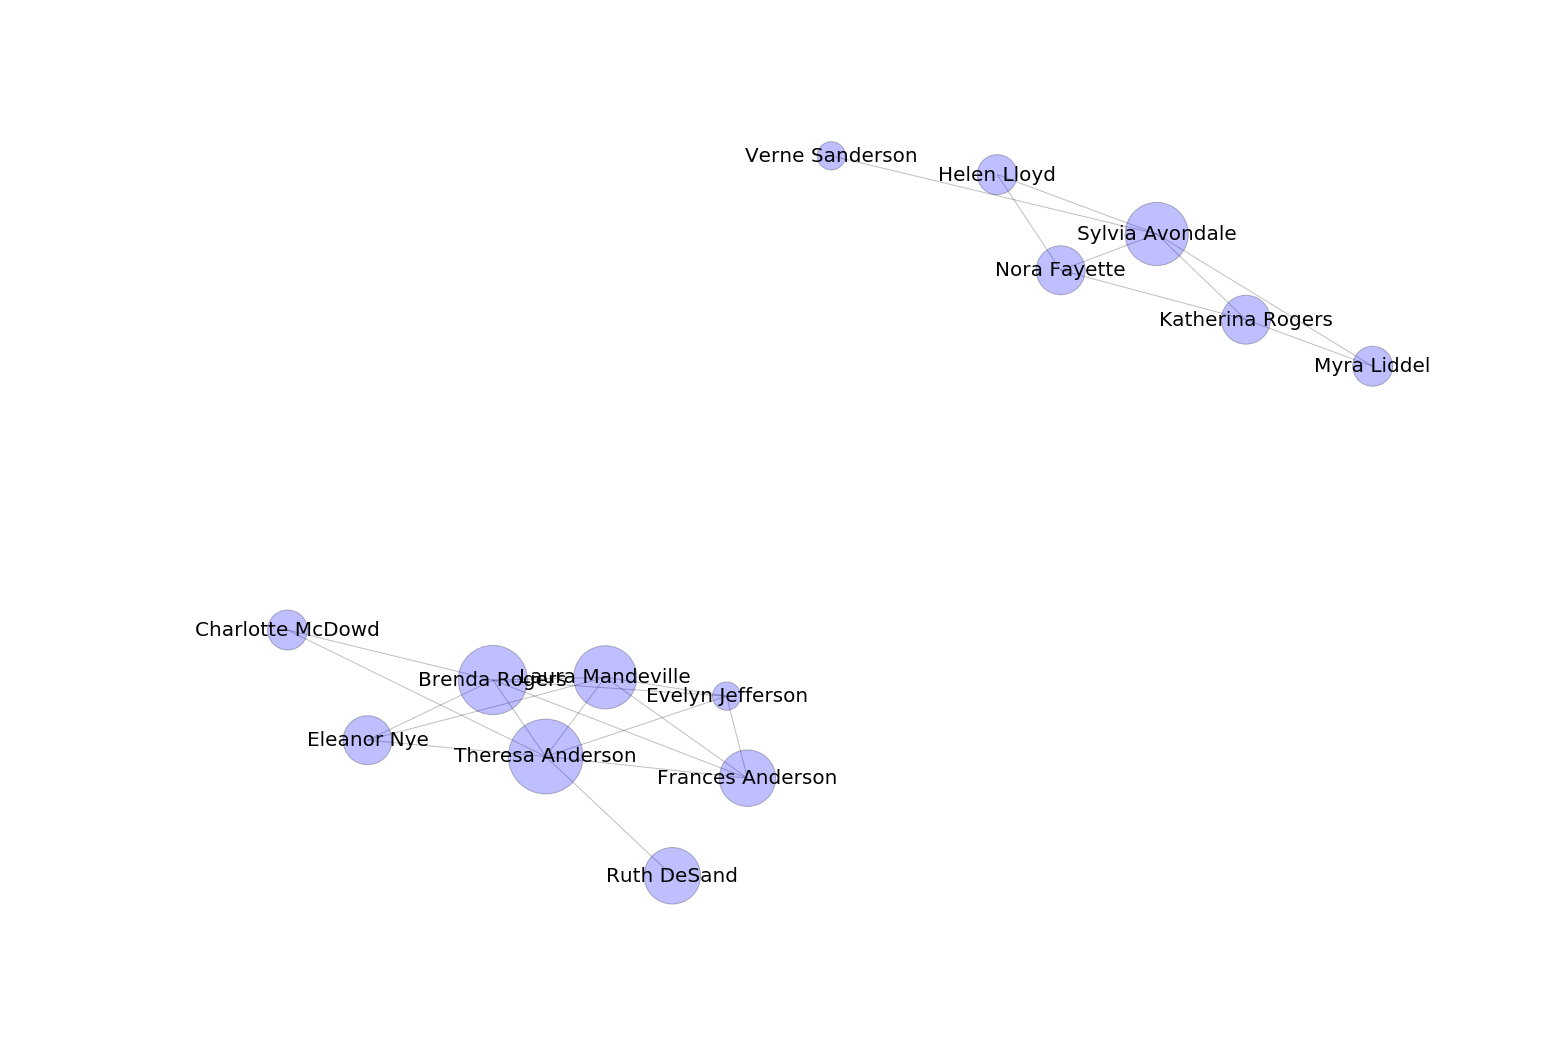

In [26]:
wc2 = trim_edges(W2, 3)
dwc2 = wc2.degree()
nx.draw(wc2, node_size=[v*800 for v in dwc2.values()], with_labels=True, node_color='b', alpha=.25, font_size=20)

In [27]:
## Who is in the first subgroup?
wc2a = list(nx.connected_component_subgraphs(wc2))[0]
wc2adeg = sorted(zip(wc2a.degree(women, weight='weight').values(), wc2a.degree(women, weight='weight').keys()), reverse=True)

print ''
print "Weight     Member"
print '---------------------------'
for i in range(len(wc2adeg)):
    print ' %2d        %s' % (wc2adeg[i][0], wc2adeg[i][1])


Weight     Member
---------------------------
 35        Theresa Anderson
 30        Brenda Rogers
 26        Laura Mandeville
 23        Evelyn Jefferson
 16        Frances Anderson
 12        Eleanor Nye
  8        Charlotte McDowd
  4        Ruth DeSand


In [28]:
## Who is in the second subgroup?

wc2b = list(nx.connected_component_subgraphs(wc2))[1]
wc2bdeg = sorted(zip(wc2b.degree(women, weight='weight').values(), wc2b.degree(women, weight='weight').keys()), reverse=True)

print ''
print "Links    Member"
print '--------------------------'
for i in range(len(wc2bdeg)):
    print ' %2d        %s' % (wc2bdeg[i][0], wc2bdeg[i][1])


Links    Member
--------------------------
 24        Sylvia Avondale
 15        Nora Fayette
 15        Katherina Rogers
  8        Myra Liddel
  8        Helen Lloyd
  4        Verne Sanderson


In [29]:
## Who did we drop? These are our connectors between the two subgroups
connectors = list(set(W2.degree(women, weight='weight').keys()) - set(wc2.degree(women, weight='weight').keys()))
# print connectors
print ''
print 'Sub-Group Connectors'
print '----------------------'
for i in range(len(connectors)):
    print connectors[i]


Sub-Group Connectors
----------------------
Olivia Carleton
Dorothy Murchison
Pearl Oglethorpe
Flora Price


## 5. Betweenness centrality, clustering coefficients

### 5.1 Clustering coefficients

The women are all very tightly connected, so clustering coefficients don't do much to distinguish subgroups. According to [Osphal](https://toreopsahl.com/tnet/two-mode-networks/clustering/), traditional clustering methods are problematic for two-mode networks and projected networks, creating further ambiguity.

In [30]:
## women sorted by clustering coefficient

c_coefs = bp.clustering(G, women)
clust_coef = sorted(zip(c_coefs.values(), c_coefs.keys()), reverse=True)

print ''
print "Clustering"
print "Coefficient  Member"
print '------------------------------'
for i in range(len(clust_coef)):
    print ' %f    %s' % (clust_coef[i][0], clust_coef[i][1])


Clustering
Coefficient  Member
------------------------------
 0.371819    Theresa Anderson
 0.364912    Brenda Rogers
 0.364356    Ruth DeSand
 0.360317    Eleanor Nye
 0.351817    Laura Mandeville
 0.348833    Verne Sanderson
 0.332341    Pearl Oglethorpe
 0.324405    Myra Liddel
 0.322752    Sylvia Avondale
 0.317943    Evelyn Jefferson
 0.314817    Frances Anderson
 0.305010    Dorothy Murchison
 0.297495    Katherina Rogers
 0.294412    Charlotte McDowd
 0.261699    Helen Lloyd
 0.260577    Nora Fayette
 0.257507    Flora Price
 0.257507    Olivia Carleton


### 5.2 Betweenness centrality
The women split into four distinct groups based on betweenness, i.e., a measure of their boundary spanner status to bridge gaps between groups. 

In [31]:
bet_cen = nx.betweenness_centrality(W)
bet_cen = sorted(zip(bet_cen.values(), bet_cen.keys()), reverse=True)

print ''
print "Betweenness"
print "Centrality    Member"
print '-------------------------------'
for i in range(len(bet_cen)):
    print ' %f     %s' % (bet_cen[i][0], bet_cen[i][1])


Betweenness
Centrality    Member
-------------------------------
 0.010122     Verne Sanderson
 0.010122     Theresa Anderson
 0.010122     Sylvia Avondale
 0.010122     Ruth DeSand
 0.010122     Nora Fayette
 0.010122     Helen Lloyd
 0.010122     Evelyn Jefferson
 0.005348     Pearl Oglethorpe
 0.005348     Myra Liddel
 0.005348     Katherina Rogers
 0.005348     Dorothy Murchison
 0.002674     Laura Mandeville
 0.002674     Frances Anderson
 0.002674     Eleanor Nye
 0.002674     Brenda Rogers
 0.000000     Olivia Carleton
 0.000000     Flora Price
 0.000000     Charlotte McDowd


### 5.3 Closeness centrality

The women separate into the same four groups based closeness, i.e., distance to all other women in the graph. 


In [32]:
clo_cen = nx.closeness_centrality(W)
clo_cen = sorted(zip(clo_cen.values(), clo_cen.keys()), reverse=True)

print ''
print "Closeness"
print "Centrality    Member"
print '-------------------------------'
for i in range(len(clo_cen)):
    print ' %f     %s' % (clo_cen[i][0], clo_cen[i][1])


Closeness
Centrality    Member
-------------------------------
 1.000000     Verne Sanderson
 1.000000     Theresa Anderson
 1.000000     Sylvia Avondale
 1.000000     Ruth DeSand
 1.000000     Nora Fayette
 1.000000     Helen Lloyd
 1.000000     Evelyn Jefferson
 0.944444     Pearl Oglethorpe
 0.944444     Myra Liddel
 0.944444     Katherina Rogers
 0.944444     Dorothy Murchison
 0.894737     Laura Mandeville
 0.894737     Frances Anderson
 0.894737     Eleanor Nye
 0.894737     Brenda Rogers
 0.772727     Olivia Carleton
 0.772727     Flora Price
 0.739130     Charlotte McDowd


### 5.4 Triangles
Women with the highest closeness and betweenness are also nodes in more triangles.

In [33]:
tri = nx.triangles(W)
tri = sorted(zip(tri.values(), tri.keys()), reverse=True)

print ''
print "Triangles    Member"
print '-------------------------------'
for i in range(len(tri)):
    print ' %3d         %s' % (tri[i][0], tri[i][1])


Triangles    Member
-------------------------------
 122         Verne Sanderson
 122         Theresa Anderson
 122         Sylvia Avondale
 122         Ruth DeSand
 122         Nora Fayette
 122         Helen Lloyd
 122         Evelyn Jefferson
 112         Pearl Oglethorpe
 112         Myra Liddel
 112         Katherina Rogers
 112         Dorothy Murchison
 101         Laura Mandeville
 101         Frances Anderson
 101         Eleanor Nye
 101         Brenda Rogers
  66         Olivia Carleton
  66         Flora Price
  55         Charlotte McDowd


## 6. Hierarchal Clustering

Using hierarcal clustering algorithms produces two groupings. The first cluster has 10 women and the second has 8 women. The groupings are not the same as those produced using the island method. First we load the a function to create the clusters. A threshhold parameter controls how many groups are produced. For this data, dropping below t=0.75 creates creates 7 groups, too many for meaningful analysis.

In [34]:
## function to create hierarchal clusters from textbook

def create_hc(G, t=1.0):
    """
    Creates hierarchical cluster of graph G from distance matrix
    Maksim Tsvetovat ->> Generalized HC pre- and post-processing to work on labelled graphs and return labelled clusters
    The threshold value is now parameterized; useful range should be determined experimentally with each dataset
    """

    """Modified from code by Drew Conway"""
    
    ## Create a shortest-path distance matrix, while preserving node labels
    labels=G.nodes()    
    path_length=nx.all_pairs_shortest_path_length(G)
    distances=np.zeros((len(G),len(G))) 
    i=0   
    for u,p in path_length.items():
        j=0
        for v,d in p.items():
            distances[i][j]=d
            distances[j][i]=d
            if i==j: distances[i][j]=0
            j+=1
        i+=1
    
    # Create hierarchical cluster
    Y=distance.squareform(distances)
    Z=hierarchy.complete(Y)  # Creates HC using farthest point linkage
    # This partition selection is arbitrary, for illustrive purposes
    membership=list(hierarchy.fcluster(Z,t=t))
    # Create collection of lists for blockmodel
    partition=defaultdict(list)
    for n,p in zip(list(range(len(G))),membership):
        partition[p].append(labels[n])
    return list(partition.values())


### 6.1 Two hierarchal clusters from projected bipartite graph

In [35]:
## create the clusters from our bipartite graph
clusters = create_hc(W, .75)

print ''
print "Hierarchal Cluster 1"
print '--------------------'
for i in range(len(clusters[0])):
    print ' %s' % (clusters[0][i])
print ''
print "Hierarchal Cluster 2"
print '--------------------'
for i in range(len(clusters[1])):
    print ' %s' % (clusters[1][i])



Hierarchal Cluster 1
--------------------
 Theresa Anderson
 Flora Price
 Katherina Rogers
 Nora Fayette
 Sylvia Avondale
 Verne Sanderson
 Olivia Carleton
 Dorothy Murchison
 Evelyn Jefferson
 Myra Liddel

Hierarchal Cluster 2
--------------------
 Pearl Oglethorpe
 Brenda Rogers
 Eleanor Nye
 Frances Anderson
 Ruth DeSand
 Laura Mandeville
 Charlotte McDowd
 Helen Lloyd


### 6.2 Plot of hierarchal clusters

Blue = Cluster 1, Red = Cluster 2

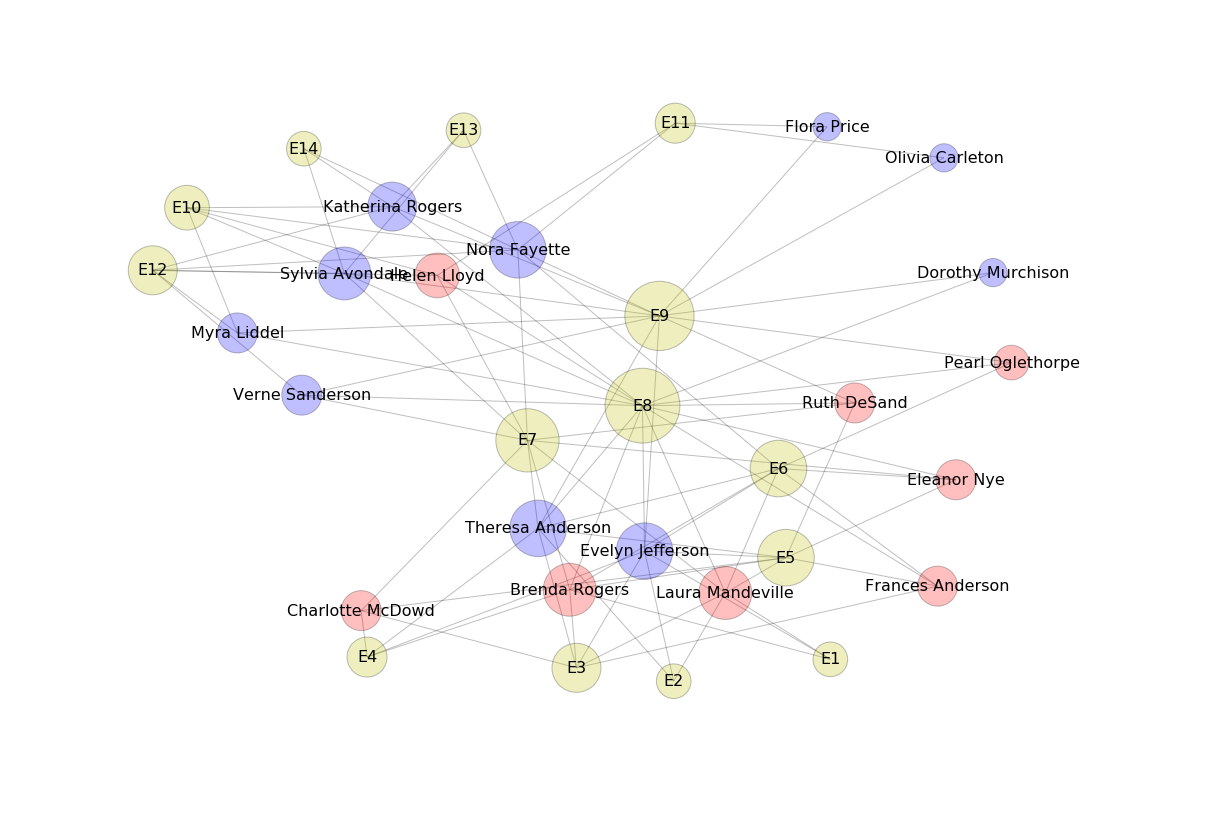

In [36]:
## plot the original network and color the women nodes according to clusters

plot.axis('off')


'''
shapes=[]
for n in G.degree().keys():
    if n in high_bet:
        nodes.append("^")
    else:
        nodes.append("o")
'''

colors=[]
for n in G.degree().keys():
    if n in G.degree(clusters[0]).keys():
        colors.append('b')
    elif n in G.degree(clusters[1]).keys():
        colors.append('r')
    else:
        colors.append('y')
        
d = G.degree()
nx.draw(G, node_size=[v*400 for v in d.values()], with_labels=True, node_color=colors, alpha=.25, font_size=16)
plot.show()


## 7. Comparing groups, methods
The two approaches, the island method and hierarchal clustering, produced similar but not identical primary subgroups of Southern Women as shown in the tables below.

In [37]:
hclust1 = set(clusters[0]); hclust2 = set(clusters[1])

iclust1 = []
for i in range(len(wc1deg)): 
    iclust1.append(wc1deg[i][1])

    iclust2 = []
for i in range(len(wc2deg)): 
    iclust2.append(wc2deg[i][1])

iclust1 = set(iclust1); iclust2 = set(iclust2)

In [38]:
hclust1 = sorted(list(hclust1))
hclust2 = sorted(list(hclust2))
iclust1 = sorted(list(iclust1))
iclust2 = sorted(list(iclust2))

In [39]:
print ''
print ''
print "SUBGROUP COMPARISON"
print "==================="
print ''
print "Island Method, Subgroup 1"
print "-------------------------"
for i in range(len(iclust1)):
    print ' %s' % (iclust1[i])
print ''
print "Hierarchal Method, Subgroup 1"
print "-----------------------------"
for i in range(len(hclust2)):
    print ' %s' % (hclust2[i])
print ''
print "Difference: Evelyn Jefferson, Theresa Anderson"
print ''
print "Island Method, Subgroup 2"
print "-------------------------"
for i in range(len(iclust2)):
    print ' %s' % (iclust2[i])
print ''
print "Hierarchal Method, Subgroup 2"
print "-----------------------------"
for i in range(len(hclust1)):
    print ' %s' % (hclust1[i])
print ''
print 'Difference:  Dorothy Murchison, Evelyn Jefferson,'
print '             Flora Price, Olivia Carleton,'
print '             Theresa Anderson'
print ''




SUBGROUP COMPARISON

Island Method, Subgroup 1
-------------------------
 Brenda Rogers
 Charlotte McDowd
 Eleanor Nye
 Evelyn Jefferson
 Frances Anderson
 Laura Mandeville
 Ruth DeSand
 Theresa Anderson

Hierarchal Method, Subgroup 1
-----------------------------
 Brenda Rogers
 Charlotte McDowd
 Eleanor Nye
 Frances Anderson
 Helen Lloyd
 Laura Mandeville
 Pearl Oglethorpe
 Ruth DeSand

Difference: Evelyn Jefferson, Theresa Anderson

Island Method, Subgroup 2
-------------------------
 Helen Lloyd
 Katherina Rogers
 Myra Liddel
 Nora Fayette
 Sylvia Avondale
 Verne Sanderson

Hierarchal Method, Subgroup 2
-----------------------------
 Dorothy Murchison
 Evelyn Jefferson
 Flora Price
 Katherina Rogers
 Myra Liddel
 Nora Fayette
 Olivia Carleton
 Sylvia Avondale
 Theresa Anderson
 Verne Sanderson

Difference:  Dorothy Murchison, Evelyn Jefferson,
             Flora Price, Olivia Carleton,
             Theresa Anderson



### 7.1 Connecting paths

The network clearly shows that Subgroup 1 women (blue nodes) are connected by attendance in a constellation of club events E1-E7, while women in Subgroup 2 (red nodes) are bound by a constellation of participation in club events E10-E14. The shortest paths connecting the two groups run though clubs/events E8-E9 (see next table). Dorothy Murchison, Pearl Ogelthorpe, Ruth Deshand and Verne Sanderson appear to be boundary spanners.

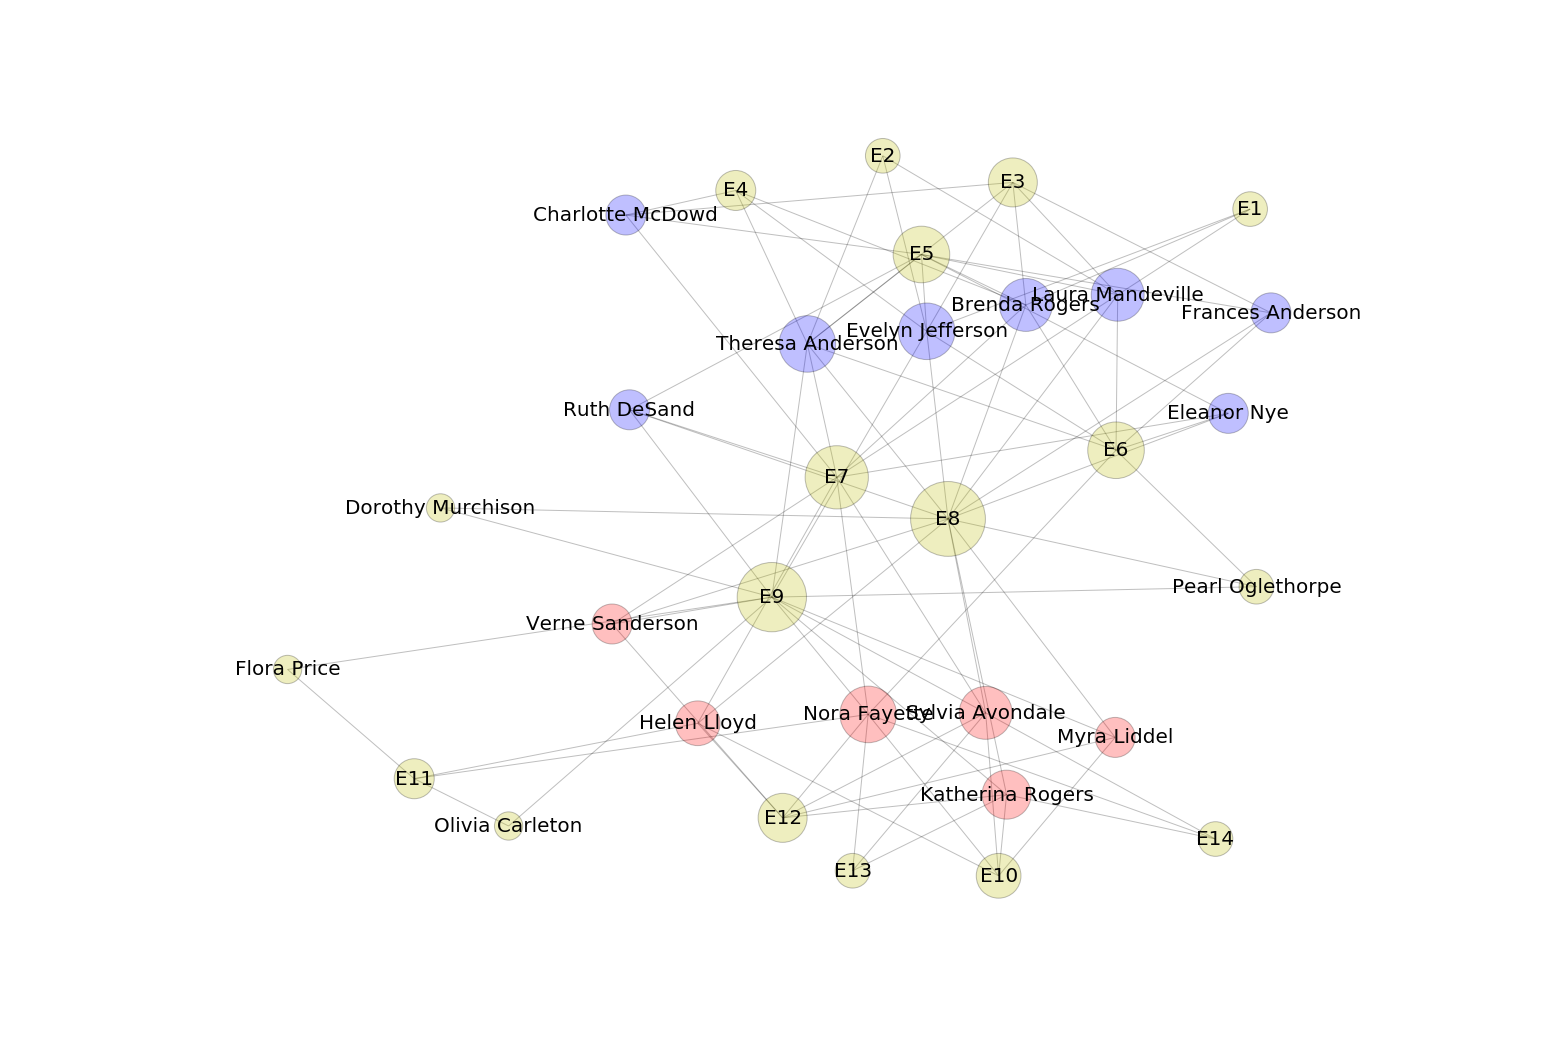

In [40]:
## plot the whole network, blue=clubs, red=women, node_size=G.degree

#plot.axis('off')

colors=[]
for n in G.degree().keys():
    if n in iclust1:
        colors.append('b')
    elif n in iclust2:
        colors.append('r')
    else:
        colors.append('y')
        
d = G.degree()
nx.draw(G, node_size=[v*400 for v in d.values()], with_labels=True, node_color=colors, alpha=.25, font_size=20)
#plot.show()


### 7.2 Connecting events, shortest paths

The following table of shortest paths confirms that participation in clubs/events E7-E9 connect the subgroups identified using the island method.

In [41]:
paths = []
for n in range(len(iclust1)):
    for i in range(len(iclust2)):
        paths.append(nx.shortest_path(G, iclust1[n], iclust2[i]))

In [42]:
        print ''
print 'Subgroup 1              Path      Subgroup 2'
print '---------------------------------------------------'
for n in range(len(paths)):
    print '%-16s        %s        %s' % (paths[n][0], paths[n][1], paths[n][2])


Subgroup 1              Path      Subgroup 2
---------------------------------------------------
Brenda Rogers           E7        Helen Lloyd
Brenda Rogers           E8        Katherina Rogers
Brenda Rogers           E8        Myra Liddel
Brenda Rogers           E7        Nora Fayette
Brenda Rogers           E8        Sylvia Avondale
Brenda Rogers           E7        Verne Sanderson
Charlotte McDowd        E7        Helen Lloyd
Charlotte McDowd        E7        Nora Fayette
Charlotte McDowd        E7        Nora Fayette
Charlotte McDowd        E7        Nora Fayette
Charlotte McDowd        E7        Sylvia Avondale
Charlotte McDowd        E7        Verne Sanderson
Eleanor Nye             E7        Helen Lloyd
Eleanor Nye             E8        Katherina Rogers
Eleanor Nye             E8        Myra Liddel
Eleanor Nye             E7        Nora Fayette
Eleanor Nye             E8        Sylvia Avondale
Eleanor Nye             E7        Verne Sanderson
Evelyn Jefferson        E8        H